Cat Dog Classification
===

In [1]:
import tensorflow as tf
import os
import re
import numpy as np
import zipfile
import matplotlib.pyplot as plt

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn
from tensorflow.contrib.learn import RunConfig as run_config

slim = tf.contrib.slim

### Utility function
Image reader, Input pipeline, etc.

In [2]:
CAT = 0
DOG = 1
IS_LOW_MEMORY_MODE = True

cwd = os.getcwd()
np.random.seed(2124)

In [3]:
def prepare_file():
  file_list = ['train', 'test']
  valid = True

  for i in range(len(file_list)):
    filename = file_list[i] + '.zip'
    dest_filename = os.path.join(cwd, 'data', filename)

    if not os.path.exists(dest_filename):
      print('Please download ' + filename + ' and put on src/data folder')
      url = "https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/"
      print(url + filename)
      valid = False
      continue
    
    images_path = os.path.join(cwd, 'data', file_list[i])

    zip = zipfile.ZipFile(dest_filename)
    if not os.path.exists(images_path):
        print('Extracting...')
        zip.extractall(os.path.join(cwd, 'data'))
      
  return valid

def read_image_label_list(folder_dir):
    dir_list = os.listdir(os.path.join(cwd, folder_dir))
    
    filenames = []
    labels = []
    
    for i, d in enumerate(dir_list):
        if re.search("train", folder_dir):
            if re.search("cat", d):
                labels.append(CAT)
            else:
                labels.append(DOG)
        else:
            labels.append(-1)
        filenames.append(os.path.join(cwd, folder_dir, d))
    
    return filenames, labels

def read_images_from_disk(input_queue):
    filename = input_queue[0]
    label = input_queue[1]
    
    file_contents = tf.read_file(filename)
    image = tf.image.decode_image(file_contents, channels=3)
    image.set_shape([None, None, 3])
    
    return image, label

def gen_input_fn(image_list, label_list, batch_size, shuffle):
    
    def input_fn():
        images = tf.convert_to_tensor(image_list, dtype=tf.string)
        labels = tf.convert_to_tensor(label_list, dtype=tf.int32)

        input_queue = tf.train.slice_input_producer(
            [images, labels],
            capacity=batch_size * 5,
            shuffle=shuffle,
            name="file_input_queue"
        )

        image, label = read_images_from_disk(input_queue)

        image = tf.image.resize_images(image, (224, 224), tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        image_batch, label_batch = tf.train.batch(
            [image, label],
            batch_size=batch_size,
            num_threads=1,
            name="batch_queue",
            capacity=batch_size * 10,
            allow_smaller_final_batch = False
        )
        
        return (
            tf.identity(image_batch, name="features"), 
            tf.identity(label_batch, name="label")
        )

    return input_fn

def train_valid_input_fn(data_dir, train_batch_size, valid_batch_size=None):
    img, labels = read_image_label_list(data_dir)
    img = np.array(img)
    labels = np.array(labels)
    data_size = img.shape[0]

    print("Data size: " + str(data_size))
    split = int(0.7 * data_size)

    random_seq = np.random.permutation(data_size)

    img = img[random_seq]
    labels = labels[random_seq]
    
    if valid_batch_size == None:
        valid_batch_size = train_batch_size

    return (
        gen_input_fn(img[0:split], labels[0:split], train_batch_size, shuffle = True),
        gen_input_fn(img[split:], labels[split:], valid_batch_size, shuffle = False)
    )

def test_input_fn(data_dir, batch_size):
    image_list, label_list = read_image_label_list(data_dir)
    return gen_input_fn(image_list, label_list, batch_size, shuffle = False), image_list

### Preview Data
Check correctness of data

In [4]:
if prepare_file():
    print "Files are ready \o/"

Files are ready \o/


Data size: 25000


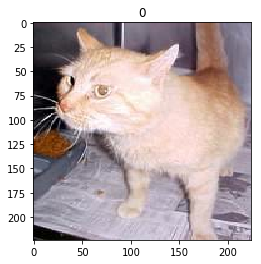

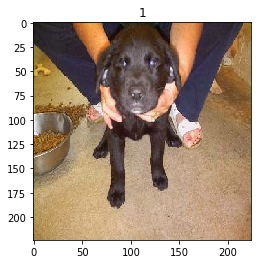

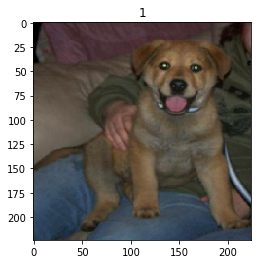

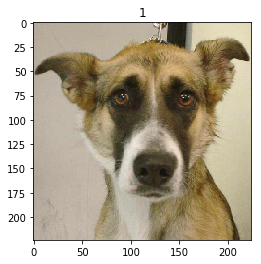

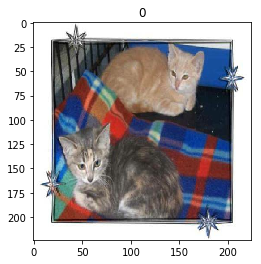

In [5]:
def plot_img(data, label=None):
    plt.ion()
    plt.figure()
    plt.imshow(data)
    if label is not None:
        plt.title(label)

def preview_img():
    
    img_preview = tf.Graph()
    
    with img_preview.as_default():
        tensor_train, _ = train_valid_input_fn('data/train', 5)
        result = tf.tuple(tensor_train())
        
    with tf.Session(graph=img_preview) as sess:
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        images, labels = sess.run(result)
        for i in range(len(images)):
            plot_img(images[i], str(labels[i]))

        coord.request_stop()
        coord.join(threads)

        sess.close()

preview_img()

### Define Model
Create a model for using in Estimator

In [6]:
def catdog_model(inputs, is_training):
    with tf.variable_scope('catdog', values=[inputs]):
        with slim.arg_scope(
            [slim.conv2d, slim.fully_connected],
            activation_fn=tf.nn.relu6,
            weights_initializer=tf.truncated_normal_initializer(0.0, 0.01)):
            
            net = inputs
        
            if IS_LOW_MEMORY_MODE == False:
                net = slim.repeat(net, 2, slim.conv2d, 64, [3, 3], scope='conv1')
                net = slim.max_pool2d(net, [2, 2], scope='pool1')

                net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
                net = slim.max_pool2d(net, [2, 2], scope='pool2')

                net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3')
                net = slim.max_pool2d(net, [2, 2], scope='pool3')
                net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv4')
                net = slim.max_pool2d(net, [2, 2], scope='pool4')
                net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv5')
                net = slim.max_pool2d(net, [2, 2], scope='pool5')

                net = tf.reshape(net, [-1, 7 * 7 * 512])

                net = slim.fully_connected(net, 2048, scope='fc6')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout6')

                net = slim.fully_connected(net, 2048, scope='fc7')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout7')

                net = slim.fully_connected(net, 2, activation_fn=None, scope='fc8')
                
            else:
                # Model for my Mac T_T
                net = tf.image.resize_images(net, (72, 72), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
                
                net = slim.repeat(net, 1, slim.conv2d, 64, [3, 3], scope='conv1')
                net = slim.max_pool2d(net, [2, 2], scope='pool1')
                
                net = slim.repeat(net, 1, slim.conv2d, 128, [3, 3], scope='conv2')
                net = slim.max_pool2d(net, [2, 2], scope='pool2')
                
                net = slim.repeat(net, 2, slim.conv2d, 256, [3, 3], scope='conv3')
                net = slim.max_pool2d(net, [2, 2], scope='pool3')
                
                net = tf.reshape(net, [-1, 9 * 9 * 256])
                
                net = slim.fully_connected(net, 1024, scope='fc4')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout4')

                net = slim.fully_connected(net, 1024, scope='fc5')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout5')

                net = slim.fully_connected(net, 2, activation_fn=None, scope='fc6')
            
            return net

In [7]:
def catdog_model_fn(features, labels, mode, params):
    
    is_training = False
    if mode == learn.ModeKeys.TRAIN:
        is_training = True
        
    output = catdog_model(features, is_training)
    
    log_loss = None
    train_op = None
    eval_metric_ops = None
    
    softmax_predictions = tf.nn.softmax(output)
    
    if mode != learn.ModeKeys.INFER:
        onehot_labels = tf.one_hot(
            tf.cast(labels, tf.int32), 
            depth = 2
        )
        log_loss = tf.identity(
            tf.losses.log_loss(
                onehot_labels,
                tf.nn.softmax(output),
                reduction = tf.losses.Reduction.MEAN
            ),
            name = "log_loss_tensor"
        )
        eval_metric_ops = {
            "log_loss": log_loss
        }
        
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss = log_loss,
            global_step = tf.contrib.framework.get_global_step(),
            learning_rate = params['learning_rate'],
            optimizer = "Adam"
        )
        
    predictions = {
        'predict': softmax_predictions
    }
    
    return model_fn.ModelFnOps(
        mode = mode,
        predictions = predictions,
        loss = log_loss,
        train_op = train_op,
        eval_metric_ops = eval_metric_ops
    )

Define model classifier

In [8]:
def feature_engineering_fn(features, labels):
    features = tf.to_float(features)
    features = tf.map_fn(tf.image.per_image_standardization, features)

    return features, labels

tf.logging.set_verbosity(tf.logging.ERROR)

model_path = '_model/catdog_low' if IS_LOW_MEMORY_MODE else '_model/catdog_vgg'
classifier = learn.Estimator(
    model_fn = catdog_model_fn, 
    model_dir = model_path + '_v2',
    config = run_config(
        save_summary_steps = 10,
        keep_checkpoint_max = 3,
        save_checkpoints_steps = 75
    ),
    feature_engineering_fn = feature_engineering_fn,
    params = {
        'learning_rate': 0.01
    }
)

train_input_fn, validate_input_fn = train_valid_input_fn('data/train', 32, 64)

logging_hook = tf.train.LoggingTensorHook(
    tensors = {
        'log_loss': 'log_loss_tensor'
    }, 
    every_n_iter = 3
)

validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    input_fn = validate_input_fn,
    eval_steps = 30,
    every_n_steps = 100,
    name = 'Validatation'
)

Data size: 25000


Let its trainnnn !!!

In [9]:
tf.logging.set_verbosity(tf.logging.INFO)

classifier.fit(
    input_fn = train_input_fn,
    steps = 100,
    monitors = [logging_hook, validation_monitor]
)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from _model/catdog_low_v2/model.ckpt-3467
INFO:tensorflow:Saving checkpoints for 3468 into _model/catdog_low_v2/model.ckpt.
INFO:tensorflow:loss = 0.360817, step = 3468
INFO:tensorflow:log_loss = 0.360817
INFO:tensorflow:Starting evaluation at 2017-07-15-04:48:47
INFO:tensorflow:Restoring parameters from _model/catdog_low_v2/model.ckpt-3468
INFO:tensorflow:Evaluation [1/30]
INFO:tensorflow:Evaluation [2/30]
INFO:tensorflow:Evaluation [3/30]
INFO:tensorflow:Evaluation [4/30]
INFO:tensorflow:Evaluation [5/30]
INFO:tensorflow:Evaluation [6/30]
INFO:tensorflow:Evaluation [7/30]
INFO:tensorflow:Evaluation [8/30]
INFO:tensorflow:Evaluation [9/30]
INFO:tensorflow:Evaluation [10/30]
INFO:tensorflow:Evaluation [11/30]
INFO:tensorflow:Evaluation [12/30]
INFO:tensorflow:Evaluation [13/30]
INFO:tensorflow:Evaluation [14/30]
INFO:tensorflow:Evaluation [15/30]
INFO:tensorflow:Evaluation [16/30]
INFO:tensorflow:Evaluatio

Estimator(params={'learning_rate': 0.01})

In [11]:
classifier.evaluate(
    input_fn = validate_input_fn,
    steps = 75
)

INFO:tensorflow:Starting evaluation at 2017-07-15-04:51:48
INFO:tensorflow:Restoring parameters from _model/catdog_low_v2/model.ckpt-3567
INFO:tensorflow:Evaluation [1/75]
INFO:tensorflow:Evaluation [2/75]
INFO:tensorflow:Evaluation [3/75]
INFO:tensorflow:Evaluation [4/75]
INFO:tensorflow:Evaluation [5/75]
INFO:tensorflow:Evaluation [6/75]
INFO:tensorflow:Evaluation [7/75]
INFO:tensorflow:Evaluation [8/75]
INFO:tensorflow:Evaluation [9/75]
INFO:tensorflow:Evaluation [10/75]
INFO:tensorflow:Evaluation [11/75]
INFO:tensorflow:Evaluation [12/75]
INFO:tensorflow:Evaluation [13/75]
INFO:tensorflow:Evaluation [14/75]
INFO:tensorflow:Evaluation [15/75]
INFO:tensorflow:Evaluation [16/75]
INFO:tensorflow:Evaluation [17/75]
INFO:tensorflow:Evaluation [18/75]
INFO:tensorflow:Evaluation [19/75]
INFO:tensorflow:Evaluation [20/75]
INFO:tensorflow:Evaluation [21/75]
INFO:tensorflow:Evaluation [22/75]
INFO:tensorflow:Evaluation [23/75]
INFO:tensorflow:Evaluation [24/75]
INFO:tensorflow:Evaluation [25/

{'global_step': 3567, 'log_loss': 0.39731568, 'loss': 0.43003139}

Let's predicttt !!!

In [13]:
test_fn, image_test_list = test_input_fn('data/test', 32)
test_n = len(image_test_list)

print("Test size: %d" % test_n)

result_file = open(os.path.join(cwd, 'result/result.txt'), 'w+')
result_file.write('id,label\n')

predictions = classifier.predict(input_fn = test_fn, as_iterable=True)
for i, p in enumerate(predictions):
    if i >= test_n:
        break
        
    id = image_test_list[i].split("/")[-1]
    id = id.split(".")[0]

    if i % 100 == 0:
        print("Predict %d %s: %f" % (i, image_test_list[i], p["predict"][1]))

    result_file.write("%s,%f\n" % (id, p["predict"][1]))

result_file.flush()
result_file.close()
print('Finish!!')

Test size: 12500
INFO:tensorflow:Restoring parameters from _model/catdog_low_v2/model.ckpt-3567
Predict 0 /notebooks/data/test/1.jpg: 0.516229
Predict 100 /notebooks/data/test/10088.jpg: 0.035159
Predict 200 /notebooks/data/test/10178.jpg: 0.413586
Predict 300 /notebooks/data/test/10268.jpg: 0.835239
Predict 400 /notebooks/data/test/10358.jpg: 0.110783
Predict 500 /notebooks/data/test/10448.jpg: 0.999401
Predict 600 /notebooks/data/test/10538.jpg: 0.173647
Predict 700 /notebooks/data/test/10628.jpg: 0.158883
Predict 800 /notebooks/data/test/10718.jpg: 0.772044
Predict 900 /notebooks/data/test/10808.jpg: 0.401376
Predict 1000 /notebooks/data/test/10899.jpg: 0.335537
Predict 1100 /notebooks/data/test/10989.jpg: 0.002961
Predict 1200 /notebooks/data/test/11078.jpg: 0.109208
Predict 1300 /notebooks/data/test/11168.jpg: 0.365385
Predict 1400 /notebooks/data/test/11258.jpg: 0.996123
Predict 1500 /notebooks/data/test/11348.jpg: 0.212810
Predict 1600 /notebooks/data/test/11438.jpg: 0.934464
Pr